<a href="https://colab.research.google.com/github/jasoriya/Mercari-Price-Suggestion-Challenge/blob/master/DMT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


If you are installing any dependent libraries, please specify here as pre-req 
to install before running the notebook



*   textstat
*   fastai==0.7.0




In [98]:
#run to install pre-req libraries
!pip install textstat

In [99]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textstat import textstat
import math
import dask.dataframe as dd

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge"))
input_folder = '/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/'

# Any results you write to the current directory are saved as output.

['sample_submission.csv.7z', 'sample_submission_stg2.csv', 'train.tsv', 'test.tsv', 'train.pkl']


# 1. Data Preprocesing

In [0]:
# Load saved preprocessed train data and skip Data Preprocessing and Data Wrangling
train_data = pd.read_pickle(input_folder + 'train.pkl')

##1. Load the training data:

In [115]:
train_data = pd.read_csv(input_folder + 'train.tsv', sep='\t')
print("shape",np.shape(train_data))
train_data.head()

shape (1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [0]:
#keeping copy of original data
train_data_copy = train_data.copy()

Let us analyze the distribution of the continuous numerical target variable *price*. 

In [117]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [118]:
train_data.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [119]:
train_data.price.describe().apply(lambda x: format(x, 'f'))

count    1482535.000000
mean          26.737516
std           38.586066
min            0.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2009.000000
Name: price, dtype: object

Some sellers have given away items for free on the platform.

## 2. Data cleaning

### Handling missing data:

In [120]:
train_data.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [121]:
# Get the percentage of missing data for each column.
train_data.isnull().sum().div(len(train_data)*.01, axis='rows').apply(lambda x: format(x, 'f'))

train_id              0.000000
name                  0.000000
item_condition_id     0.000000
category_name         0.426769
brand_name           42.675687
price                 0.000000
shipping              0.000000
item_description      0.000270
dtype: object

The variables brand_name has a substantial amount of missing data. 

In [0]:
# train_data['name'] = train_data['name'].fillna('') + ' ' + train_data['brand_name'].fillna('')
# train_data.drop('brand_name', axis=1, inplace=True)

In [123]:
# Get the percentage of missing data for each column.
train_data.isnull().sum().div(len(train_data)*.01, axis='rows').apply(lambda x: format(x, 'f'))

train_id             0.000000
name                 0.000000
item_condition_id    0.000000
category_name        0.426769
price                0.000000
shipping             0.000000
item_description     0.000270
dtype: object

In [0]:
def fill_missing_data(data):
    data.category_name.fillna(value = "unk_cat1/unk_cat2/unk_cat3", inplace = True)
    data.brand_name.fillna(value = "unk_brand", inplace = True)
    data.item_description.fillna(value = "unk_description", inplace = True)
    return data

In [125]:
train_data = fill_missing_data(train_data)
print(np.shape(train_data))
train_data.tail(10)

(1482535, 7)


,train_id,name,item_condition_id,category_name,price,shipping,item_description
1482525,1482525,Red Victoria's Secret bra w sequins PINK,2,Women/Underwear/Bras,7.0,1,Removable straps to make strapless Size: 34 B ...
1482526,1482526,Harry Potter Shirt! Women M/ Girl XL,2,Women/Tops & Blouses/T-Shirts,12.0,0,"Great Harry Potter Shirt! ""Hogwarts, School of..."
1482527,1482527,Blk/white ribbed mock neck bodysuit M,1,Women/Tops & Blouses/Blouse,10.0,1,Brand new black and white ribbed mock neck bod...
1482528,1482528,Victoria's Secret Tankini Sz. Large Victoria's...,2,Women/Athletic Apparel/Sports Bras,18.0,1,Purple and Paisley Victoria's Secret Tankini S...
1482529,1482529,Men's UA [rm] Under Armour,2,Men/Athletic Apparel/Shirts & Tops,34.0,0,[rm] for the set both in perfect condition no ...
1482530,1482530,Free People Inspired Dress Free People,2,Women/Dresses/Mid-Calf,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress Disney,2,Kids/Girls 2T-5T/Dresses,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,45.0,1,There is 2 of each one that you see! So 2 red ...
1482534,1482534,Brand new lux de ville wallet,1,Women/Women's Accessories/Wallets,22.0,0,"New with tag, red with sparkle. Firm price, no..."


In [126]:
train_data.isnull().any()

train_id             False
name                 False
item_condition_id    False
category_name        False
price                False
shipping             False
item_description     False
dtype: bool

In [127]:
# number of unique values for each column
train_data.nunique()

train_id             1482535
name                 1266163
item_condition_id          5
category_name           1288
price                    828
shipping                   2
item_description     1281427
dtype: int64

In [0]:
def remove_whitespace( x ):
    if isinstance( x, str ):
        return x.strip()
    else:
        return x

train_data = train_data.applymap(remove_whitespace)

In [129]:
# number of unique values for each column
train_data.nunique()

train_id             1482535
name                 1266096
item_condition_id          5
category_name           1288
price                    828
shipping                   2
item_description     1281427
dtype: int64

In [0]:
# Standardize target variable price
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
scalar.fit(train_data.price.values.reshape(-1,1))
train_data['price'] = scalar.transform(train_data.price.values.reshape(-1,1))

In [131]:
train_data.head()

,train_id,name,item_condition_id,category_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,-0.433771,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard Razer,3,Electronics/Computers & Tablets/Components & P...,0.654705,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse Target,1,Women/Tops & Blouses/Blouse,-0.433771,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,0.214131,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,0.447376,0,Complete with certificate of authenticity


# 2. Data Wrangling

In [132]:
train_data = pd.get_dummies(train_data, columns=['item_condition_id'])
train_data.head()

# # For now, we will not use OHE, and would use Entity Embeddings on this 
# # variable as well. 
# pd.get_dummies(train_data, columns=['item_condition_id']).head()


,train_id,name,category_name,price,shipping,item_description,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,-0.433771,1,No description yet,0,0,1,0,0
1,1,Razer BlackWidow Chroma Keyboard Razer,Electronics/Computers & Tablets/Components & P...,0.654705,0,This keyboard is in great condition and works ...,0,0,1,0,0
2,2,AVA-VIV Blouse Target,Women/Tops & Blouses/Blouse,-0.433771,1,Adorable top with a hint of lace and a key hol...,1,0,0,0,0
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,0.214131,1,New with tags. Leather horses. Retail for [rm]...,1,0,0,0,0
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,0.447376,0,Complete with certificate of authenticity,1,0,0,0,0


The columns name, item_condition_id, category_name, brand_name have categorical values. Categorical values can be converted to One Hot Encoding to feed into a machine learning model. The column has fixed 5 unique values and we will transform that using OHE. 

The other remaining variables do not have fixed unique values, that can be problematic in OHE if the test dataset has new unique values/categories. These other variables alo have a large number of unique values, and this will create a very sparse matrix. Due to these problems, we will not transform them to OHE for now.

In [0]:
len(train_data.category_name.apply(lambda x: len(x.split('/'))) == 3)

1482535

Every category has 3 subparts. We can split them into individual subparts.

In [0]:
train_data = pd.concat([train_data, train_data.category_name.str.split('/', n = 2, expand=True).rename({0: 'cat_1', 1: 'cat_2', 2: 'cat_3'}, axis=1)], axis=1)
train_data.head()

,train_id,name,category_name,brand_name,price,shipping,item_description,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,unk_brand,10.0,1,No description yet,0,0,1,0,0,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,0,0,1,0,0,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,1,0,0,0,0,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,unk_brand,35.0,1,New with tags. Leather horses. Retail for [rm]...,1,0,0,0,0,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,unk_brand,44.0,0,Complete with certificate of authenticity,1,0,0,0,0,Women,Jewelry,Necklaces


In [0]:
# %timeit train_data['item_description'].apply(lambda x: textstat.gunning_fog(x) if x is not '' and x.lower()!='unk' else 999)
# %timeit ddata['item_description'].apply(lambda x: textstat.gunning_fog(x) if x is not '' and x.lower()!='unk_description' else 99, meta=(None, 'float64')).compute(scheduler='multiprocessing')

In [0]:
# calculate readability score from the item_description attribute. The reasoning behind this is that a good product listing will be easy to read an concise. 
# train_data['item_description_readability_score'] = train_data['item_description'].apply(lambda x: textstat.gunning_fog(x) if x is not '' and x.lower()!='unk' else 999)
ddata = dd.from_pandas(train_data, npartitions=2)
train_data['item_description_readability_score'] = ddata['item_description'].apply(lambda x: textstat.gunning_fog(x) if x is not '' and x.lower()!='unk_description' else 99, meta=(None, 'float64')).compute(scheduler='multiprocessing')

In [0]:
train_data.head()

,train_id,name,category_name,brand_name,price,shipping,item_description,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3,item_description_readability_score
0,0,MLB Cincinnati Reds T Shirt Size XL,Men/Tops/T-shirts,unk_brand,-0.433771,1,No description yet,0,0,1,0,0,Men,Tops,T-shirts,14.53
1,1,Razer BlackWidow Chroma Keyboard,Electronics/Computers & Tablets/Components & P...,Razer,0.654705,0,This keyboard is in great condition and works ...,0,0,1,0,0,Electronics,Computers & Tablets,Components & Parts,8.13
2,2,AVA-VIV Blouse,Women/Tops & Blouses/Blouse,Target,-0.433771,1,Adorable top with a hint of lace and a key hol...,1,0,0,0,0,Women,Tops & Blouses,Blouse,5.80
3,3,Leather Horse Statues,Home/Home Décor/Home Décor Accents,unk_brand,0.214131,1,New with tags. Leather horses. Retail for [rm]...,1,0,0,0,0,Home,Home Décor,Home Décor Accents,2.12
4,4,24K GOLD plated rose,Women/Jewelry/Necklaces,unk_brand,0.447376,0,Complete with certificate of authenticity,1,0,0,0,0,Women,Jewelry,Necklaces,18.00


In [0]:
train_data.to_pickle(input_folder + 'train.pkl')

# 3. Exploratory Data Analysis

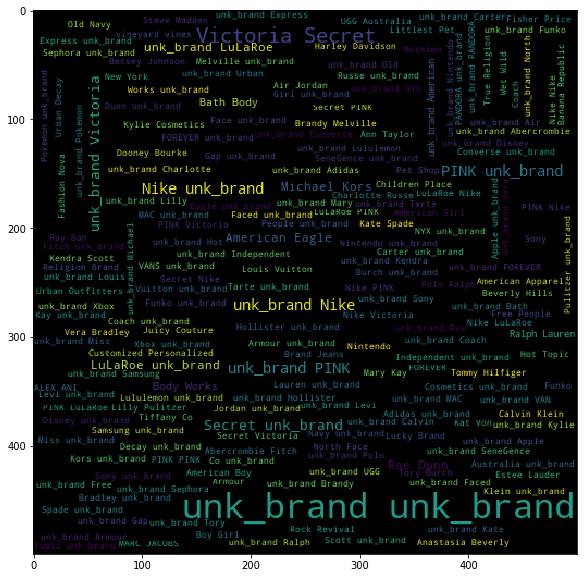

In [0]:
#!pip install wordcloud
from wordcloud import WordCloud
import os

wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(train_data.brand_name.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

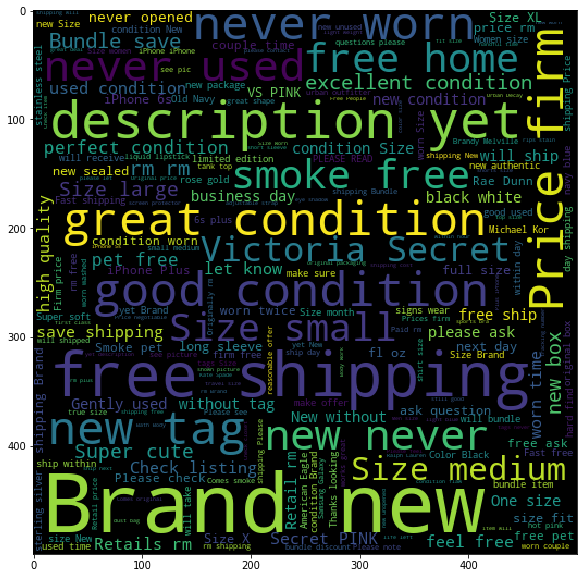

In [0]:
from wordcloud import WordCloud
import os

wordcloud = WordCloud(width = 500, height = 500).generate(" ".join(train_data.item_description.astype(str)))
plt.figure(figsize = (15, 10))
plt.imshow(wordcloud)
plt.show()

# 4. Data Modelling 

In [0]:
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model, load_model
from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Activation, Reshape, Conv1D, Flatten, MaxPooling1D
from keras.layers import Concatenate, Dropout
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from keras.utils import plot_model
import keras
import keras.backend as K

In [0]:
def rmsle(y_true, y_pred):
    assert K.int_shape(y_true)[0] == K.int_shape(y_pred)[0]
    return K.sqrt(K.mean(K.square(K.log(y_pred+1) - K.log(y_true+1))))

In [0]:
train_data.columns

Index(['train_id', 'name', 'category_name', 'brand_name', 'price', 'shipping',
       'item_description', 'item_condition_id_1', 'item_condition_id_2',
       'item_condition_id_3', 'item_condition_id_4', 'item_condition_id_5',
       'cat_1', 'cat_2', 'cat_3', 'item_description_readability_score'],
      dtype='object')

### Convert Categorical features into continuous features using Entity Embedding:  Embedding Preparation (Step 1)

### Sub-Feature Space

In [0]:
features = ['item_condition_id_1', 'item_condition_id_2', 
            'item_condition_id_3', 'item_condition_id_4', 
            'item_condition_id_5', 'cat_1', 'cat_2', 'cat_3', 
            'brand_name', 'shipping', 'item_description_readability_score']

embed_cols = ['cat_1', 'cat_2', 'cat_3', 'brand_name']
contin_vars = ['item_condition_id_1', 'item_condition_id_2', 
               'item_condition_id_3', 'item_condition_id_4', 
               'item_condition_id_5', 'shipping', 
               'item_description_readability_score']
  
target = ['price']

In [0]:
X_train, X_val, y_train, y_val = train_test_split(train_data[features], 
                                                    train_data[target], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [0]:
X_train.head()

,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3,brand_name,shipping,item_description_readability_score
1416089,0,0,1,0,0,Kids,Boys (4+),Bottoms,unk_brand,1,9.07
1423955,1,0,0,0,0,Other,Other,Other,unk_brand,0,0.80
403867,1,0,0,0,0,Beauty,Hair Care,Styling Products,unk_brand,0,4.84
701974,0,1,0,0,0,Women,Pants,Casual Pants,unk_brand,0,7.72
1124330,1,0,0,0,0,Women,Underwear,Panties,PINK,1,3.60


In [0]:
y_train.head()

,price
1416089,-0.304191
1423955,0.447376
403867,0.214131
701974,-0.200526
1124330,0.084551


In [0]:
train_data[embed_cols].nunique()

cat_1           11
cat_2          114
cat_3          872
brand_name    4810
dtype: int64

### Categorical Features To List Format

we need to convert data to list format to match the NN network structure.

The following function takes the list of categorical features, and prepare such lists for the NN input.

In [0]:
X_train.dtypes

item_condition_id_1                     uint8
item_condition_id_2                     uint8
item_condition_id_3                     uint8
item_condition_id_4                     uint8
item_condition_id_5                     uint8
cat_1                                  object
cat_2                                  object
cat_3                                  object
brand_name                             object
shipping                                int64
item_description_readability_score    float64
dtype: object

In [0]:
# Ref: https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb
def preproc(X_train, X_test):

    input_list_train = []
    input_list_test = []
    unk_in_embed = {'cat_1': 'unk_cat1', 'cat_2': 'unk_cat2', 'cat_3': 'unk_cat3', 'brand_name': 'unk_brand'}
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        # raw_vals = np.unique(X_train[c])
        raw_vals = np.unique(train_data[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_test.append(X_test[c].map(val_map).fillna(val_map[unk_in_embed[c]]).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_test

In [136]:
categorical_cols=[i for i in X_train.select_dtypes(include=['object'])]

for i in categorical_cols:
    print(i,train_data[i].nunique())

cat_1 11
cat_2 114
cat_3 872
brand_name 4810


### Embedding Dimension - Hyperparamter (to explore more...)

The choice of embedding dimension is optional, essentially it is a hyperparamter that one need to choose beforehand and reseach. 

##### One rule of thumb is to choose half of the cardinality of the categorical feature if that is is up to 50 in length.

In [137]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    no_of_unique_cat  = train_data[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    print('Categorical Variable:', categorical_var,
        'Unique Categories:', no_of_unique_cat,
        'Embedding Size:', embedding_size)

Categorical Variable: cat_1 Unique Categories: 11 Embedding Size: 6
Categorical Variable: cat_2 Unique Categories: 114 Embedding Size: 50
Categorical Variable: cat_3 Unique Categories: 872 Embedding Size: 50
Categorical Variable: brand_name Unique Categories: 4810 Embedding Size: 50


#### Proper Naming of Categorical Features for Labelling NN Layers

In [138]:
for categorical_var in X_train.select_dtypes(include=['object']):
    
    input_name= 'Input_' + categorical_var.replace(" ", "")
    print(input_name)

Input_cat_1
Input_cat_2
Input_cat_3
Input_brand_name


In [139]:
X_train.head()

,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,cat_1,cat_2,cat_3,brand_name,shipping,item_description_readability_score
1416089,0,0,1,0,0,Kids,Boys (4+),Bottoms,unk_brand,1,9.07
1423955,1,0,0,0,0,Other,Other,Other,unk_brand,0,0.80
403867,1,0,0,0,0,Beauty,Hair Care,Styling Products,unk_brand,0,4.84
701974,0,1,0,0,0,Women,Pants,Casual Pants,unk_brand,0,7.72
1124330,1,0,0,0,0,Women,Underwear,Panties,PINK,1,3.60


###  Building Neural Network (Step 2)

Here we basically make the embeding layers one at a time and append, and at the end we concatenate it together with the numerical features.

In [0]:
input_models=[]
output_embeddings=[]
numerics = ['uint8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

for categorical_var in X_train.select_dtypes(include=['object']):
    
    #Name of the categorical variable that will be used in the Keras Embedding layer
    cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'
  
    # Define the embedding_size
    # no_of_unique_cat  = X_train[categorical_var].nunique()
    no_of_unique_cat  = train_data[categorical_var].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  
    #One Embedding Layer for each categorical variable
    input_model = Input(shape=(1,))
    output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
    output_model = Reshape(target_shape=(embedding_size,))(output_model)    
  
    #Appending all the categorical inputs
    input_models.append(input_model)
  
    #Appending all the embeddings
    output_embeddings.append(output_model)
  
#Other non-categorical data columns (numerical). 
#I define single another network for the other columns and add them to our models list.
input_numeric = Input(shape=(len(X_train.select_dtypes(include=numerics).columns.tolist()),))
embedding_numeric = Dense(128)(input_numeric) 
input_models.append(input_numeric)
output_embeddings.append(embedding_numeric)

#At the end we concatenate altogther and add other Dense layers
output = Concatenate()(output_embeddings)
output = Dense(1000, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.4)(output)
output = Dense(512, kernel_initializer="uniform")(output)
output = Activation('relu')(output)
output= Dropout(0.3)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=input_models, outputs=output)
# opt = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss=rmsle, optimizer='adam')
 
# model.compile(loss='mean_squared_error', optimizer=opt,metrics=['mse']) #comment this line and uncomment above one to re-run the model

In [0]:
K.clear_session()

In [0]:
import pydot_ng as pydot

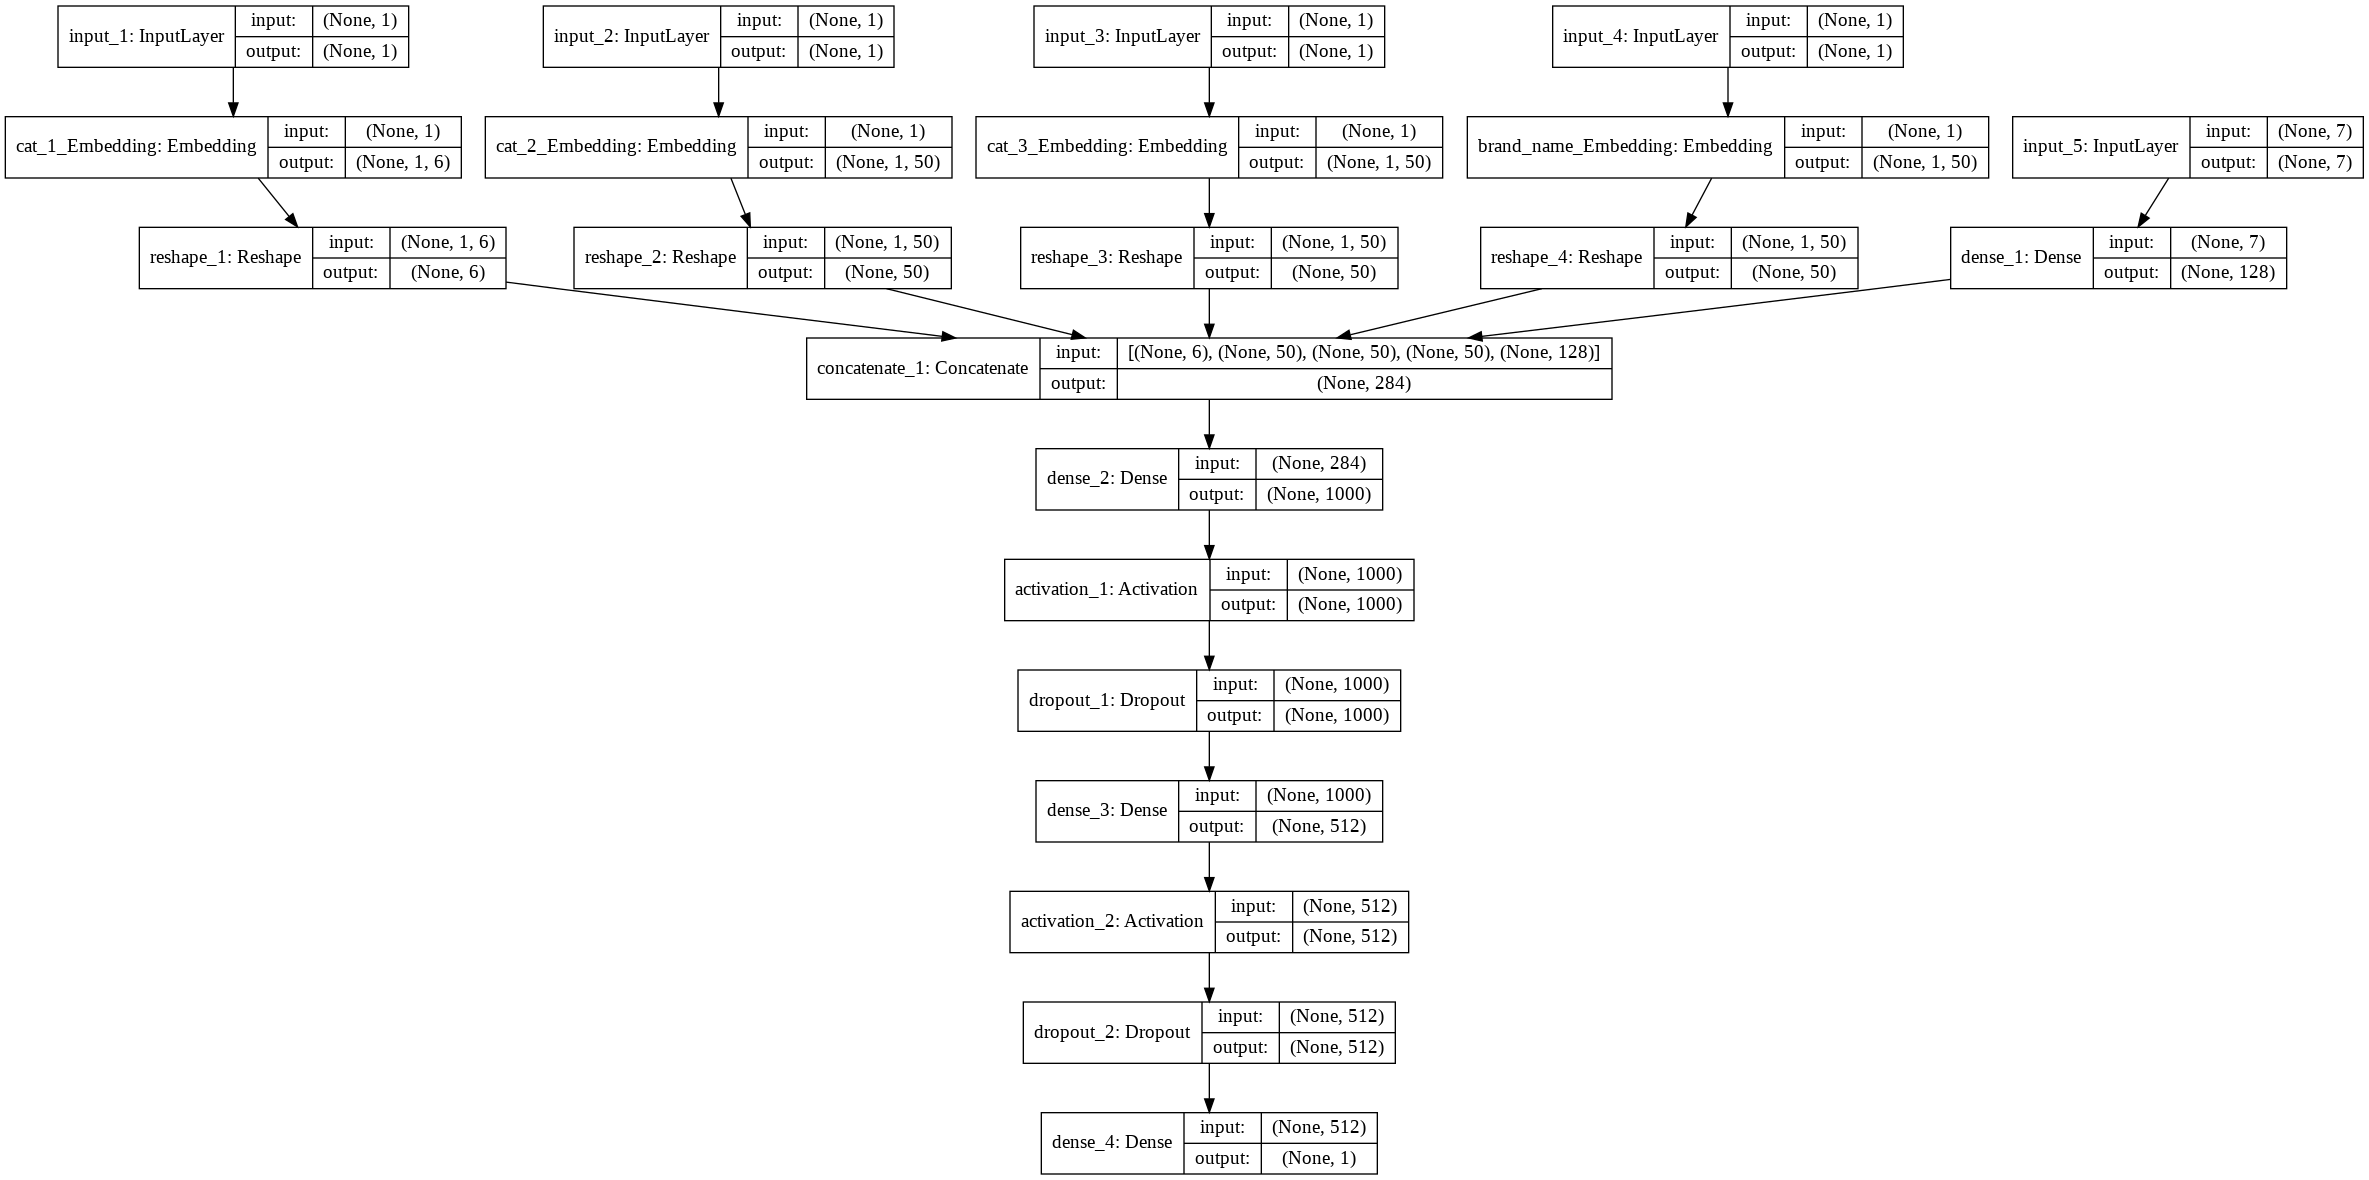

In [146]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file= input_folder + 'model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [147]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
cat_1_Embe

### Training data

In [0]:
X_train_list, X_val_list, = preproc(X_train, X_val)

In [0]:
history = History()

callbacks = [history, 
             EarlyStopping(monitor='val_loss', patience=7, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath=input_folder + 'model.best.weights.hdf5', 
             monitor='val_loss', verbose=1, 
             save_best_only=True, mode='auto')]

In [0]:
history  =  model.fit(X_train_list,y_train,validation_data=(X_val_list,y_val) , epochs = 1200 , batch_size = 512, verbose= 1, callbacks=callbacks)

Train on 1186028 samples, validate on 296507 samples
Epoch 1/1200
1186028/1186028 [==============================] - 191s 161us/step - loss: 0.5409 - val_loss: 0.5423

Epoch 00001: val_loss improved from inf to 0.54231, saving model to /content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/model.best.weights.hdf5
Epoch 2/1200
1186028/1186028 [==============================] - 191s 161us/step - loss: 0.5231 - val_loss: 0.5029

Epoch 00002: val_loss improved from 0.54231 to 0.50290, saving model to /content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/model.best.weights.hdf5
Epoch 3/1200
1186028/1186028 [==============================] - 193s 162us/step - loss: 0.5009 - val_loss: 0.5014

Epoch 00003: val_loss improved from 0.50290 to 0.50142, saving model to /content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/model.best.weights.hdf5
Epoch 4/1200
1186028/1186028 [==============================] - 193s 163us/step - loss: 0.4999 - val_loss: 0.5007

Epoch 00004

In [0]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
#List out Hyperparameters ???